In [115]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from utilities.basic import list_subdir
from utilities import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json
from scipy import spatial
import plotly.express as px
from itertools import combinations

In [2]:
data_dir = join(base_dir, 'data')
tables_dir = join(data_dir, 'tables')
data_long_dir = join(data_dir, 't1_longitudinal')
disk_dir = "F:\\"
fig_dir = join(base_dir, 't1_long','figs')
br_df = pd.read_csv(join(disk_dir,"CoBra\\Data\\volume_longitudinal_nii\\Brain_Regions.csv"))
pred_dir = join(disk_dir, "CoBra\\Data\\volume_longitudinal_nii\\prediction")
df_pat = utils.load_scan_csv(join(tables_dir, 'neg_pos_clean.csv'))
pred_df = pd.read_feather(join(data_long_dir, 'results', 'volume_prediction_results.feather'))
with open(join(data_long_dir, "sids_long_new.pkl"), 'rb') as f:
    long_sids_ls = pickle.load(f)
with open(join(data_long_dir, "sids_long_stroke.pkl"), 'rb') as f:
    stroke_sids_ls = pickle.load(f)
with open(join(tables_dir, 'newIDs_dic.pkl'), 'rb') as f:
    id_dic = pickle.load(f)
with open(join(data_long_dir, "sids_long_new.pkl"), 'rb') as f:
    sids_ls = pickle.load(f)
with open(join(tables_dir, "disk_series_directories.json"), 'rb') as f:
    dir_dic = json.load(f)
inv_id_map = {v: k for k, v in id_dic.items()}
#dcm_dirs = {newid:os.path.normpath(dir_dic[inv_id_map[newid]]) for newid in newids}

df = pred_df[pred_df.SeriesInstanceUID.isin(long_sids_ls)]
corrected_outliers = ['109983', '047205', '083072', '109644', '287546', '258402',
                '258387', '258391', '258394','258397','258402', '258403']
rerun_conversion_files = ['109983', '047205', '083072', '109644', '287546',]

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:8: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [58]:
# pred_df = pred_df[~pred_df.newID.isin(corrected_outliers)]
# pred_df = pred_df.reset_index(drop=True)
# df_scan = pd.read_feather(join(data_dir, 'tables','neg_pos_clean'), columns=['SeriesInstanceUID', 'PatientID', 'InstanceCreationDate'])
# pred_df_new = pd.merge(df_scan, pred_df, on='SeriesInstanceUID', how='right')
# pred_df_new.to_feather(join(data_long_dir,'results', 'volume_prediction_results.feather'))

## Segmented brain regions

## Whole brain volume dist

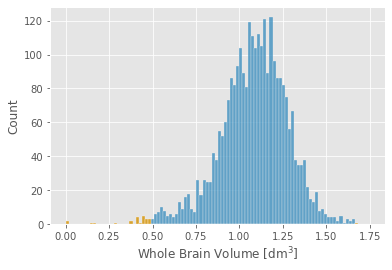

In [3]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
_,bins = np.histogram(df.Whole_Brain, bins=100, range=(0,1.75))
sns.histplot(df.Whole_Brain/1e6, ax=ax, bins=bins)
sns.histplot(df[np.abs(stats.zscore(df.Whole_Brain)) > 3].Whole_Brain/1e6,bins=bins, ax=ax, color='orange')
ax.set_xlabel('Whole Brain Volume '+r'$[\mathrm{dm}^3]$')
fig.savefig(join(fig_dir, "whole_brain_dist.png"), dpi=200)

<AxesSubplot:ylabel='Whole_Brain'>

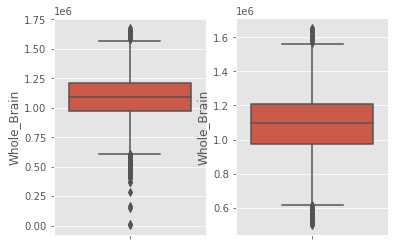

In [4]:
fig, ax = plt.subplots(1,2)
sns.boxplot(data = df, y='Whole_Brain', ax=ax[0])
sns.boxplot(data = df[np.abs(stats.zscore(df.Whole_Brain)) < 3], y='Whole_Brain', ax=ax[1])

## Outliers

In [5]:
wb_outliers_df = pred_df[np.abs(stats.zscore(pred_df.Whole_Brain)) > 3]
outliers_ids = list(wb_outliers_df.newID)


corr_sids_ls = [inv_id_map[id] for id in outliers_ids]
dcm_dirs = {sid:os.path.normpath(dir_dic[sid]) for sid in corr_sids_ls}
outliers_sids = [inv_id_map[id] for id in outliers_ids]
print(len(outliers_ids))
#print(outliers_sids)

105


In [68]:
failed_seg_paths = [(join(pred_dir, id+'_1mm.nii.gz'), join(pred_dir, id+'_1mm_seg.nii.gz')) for id in outliers_ids]
with open(join(data_long_dir, "failed_seg.pkl"), 'wb') as f:
    pickle.dump(failed_seg_paths, f)

## Brain regions of interest

In [6]:
br_ls = list(df.keys())
br_ls.remove('newID')
br_ls.remove('SeriesInstanceUID')
def get_br_ls(key=''):
    if not(isinstance(key, list)):
        ls = [f for f in br_ls if key in f]
        return ls
    else:
        ls = [f for f in br_ls if key[0] in f]
        for k in key:
            ls = [f for f in ls if k in f]
        return ls

In [9]:
affected_br_dic = {
    'left rolandic operculum':['Right_Central_Operculum', 'Left_Central_Operculum'],
    'olfactory bulb':[], 
    'bilateral insulas':get_br_ls('Insu'),
    'bilateral hipocampi':get_br_ls('Hip'),
    'right cingulate gyrus':get_br_ls(['Cing']),
    'left heschls gyrus':get_br_ls(['Trans']),
    'parahippocampal gyrus':get_br_ls('Para'),
    'anterior cingulate cortex':[],
    'temporal pole':get_br_ls('Temporal_Pole'),
    'left orbitofrontal cortex':get_br_ls('Orbital_Gyrus')
    }
print(affected_br_dic)


{'left rolandic operculum': ['Right_Central_Operculum', 'Left_Central_Operculum'], 'olfactory bulb': [], 'bilateral insulas': ['Right_Anterior_Insula', 'Right_Posterior_Insula', 'Left_Anterior_Insula', 'Left_Posterior_Insula'], 'bilateral hipocampi': ['Right_Hippocampus', 'Left_Hippocampus'], 'right cingulate gyrus': ['Right_Anterior_Cingulate_Gyrus', 'Right_Middle_Cingulate_Gyrus', 'Right_Posterior_Cingulate_Gyrus', 'Left_Anterior_Cingulate_Gyrus', 'Left_Middle_Cingulate_Gyrus', 'Left_Posterior_Cingulate_Gyrus'], 'left heschls gyrus': ['Right_Transverse_Temporal_Gyrus', 'Left_Transverse_Temporal_Gyrus'], 'parahippocampal gyrus': ['Right_Parahippocampal_Gyrus', 'Left_Parahippocampal_Gyrus'], 'anterior cingulate cortex': [], 'temporal pole': ['Right_Temporal_Pole', 'Left_Temporal_Pole'], 'left orbitofrontal cortex': ['Right_Anterior_Orbital_Gyrus', 'Right_Lateral_Orbital_Gyrus', 'Right_Medial_Orbital_Gyrus', 'Right_Posterior_Orbital_Gyrus', 'Left_Anterior_Orbital_Gyrus', 'Left_Lateral_O

In [72]:
with open(join(data_long_dir, 'final', 'affected_brain_regions_dic.pkl'), 'wb') as f:
    pickle.dump(affected_br_dic, f)

In [39]:
brain_regions_ls = [item for sublist in list(affected_br_dic.values()) for item in sublist]
brain_regions_ls.insert(0,'Whole_Brain')

### Check outliers for every brain region

In [40]:
all_brain_regions_ls = pred_df.keys()[5:]
all_brain_regions_ls.drop('Background')

Index(['Third_Ventricle', 'Right_Inferior_Lateral_Ventricle',
       'Right_Lateral_Ventricle', 'Left_Inferior_Lateral_Ventricle',
       'Left_Lateral_Ventricle', 'Right_Accumbens_Area', 'Right_Caudate',
       'Right_Putamen', 'Right_Pallidum', 'Right_Thalamus_Proper',
       ...
       'Forth_Ventricle', 'Brain_Stem', 'Right_Cerebellum_Exterior',
       'Right_Cerebellum_White_Matter', 'Left_Cerebellum_Exterior',
       'Left_Cerebellum_White_Matter', 'Cerebellar_Vermal_Lobules_I_V',
       'Cerebellar_Vermal_Lobules_VI_VII', 'Cerebellar_Vermal_Lobules_VIII_X',
       'Whole_Brain'],
      dtype='object', length=133)

In [69]:
exclude_sids_ls = []
for br in all_brain_regions_ls:
    exclude_sids_ls = exclude_sids_ls + df[np.abs(stats.zscore(df[br])) > 3].SeriesInstanceUID.to_list()

In [46]:
exclude_sids_ls = list(set(exclude_sids_ls))
print('number of excluded scans:',len(exclude_sids_ls))

number of excluded scans: 1193


In [53]:
df_clean = pred_df[~pred_df.SeriesInstanceUID.isin(exclude_sids_ls)]
print(len(pred_df), 'scans')
print(len(df_clean), 'scans after exclusion')

7762 scans
6569 scans after exclusion


## Compute pairwise distances

In [185]:
test_df = pd.DataFrame(data=np.array([['p0', 'p0', 'p0','p1', 'p1'], ['s0','s1','s2','s3','s4'], [0.0,1.,2.,3.,4.5], [10,1.,2.,3.,0],[10,1.,2.,3.,-10]]).T, 
    columns=['Patient', 'Scan', 'Value0','Value1', 'Value2'])
test_df.head()

,Patient,Scan,Value0,Value1,Value2
0,p0,s0,0.0,10,10
1,p0,s1,1.0,1.0,1.0
2,p0,s2,2.0,2.0,2.0
3,p1,s3,3.0,3.0,3.0
4,p1,s4,4.5,0,-10


In [188]:
scan_df = test_df.groupby('Patient').Scan.apply(lambda x: list(combinations(x.values,2))).apply(pd.Series).stack().reset_index(level=0,name='Scan').head()

In [190]:
values_ls = ['Value0','Value1', 'Value2']
for i, val in enumerate(values_ls):
    vdf = test_df.groupby('Patient')[val].apply(lambda x: list(combinations(x.values,2))).apply(pd.Series).stack().reset_index(level=0,name=val)
    vdf['Diff_'+val] = vdf[val].map(lambda x: float(x[1])-float(x[0]))
    vdf = pd.merge(scan_df, vdf, on='Patient', how='inner')
    vdf.drop(columns=[val], inplace=True)
    if i==0:
        vdf_temp = vdf
    else:
        vdf = pd.merge(vdf_temp.drop(columns=['Scan']), vdf, on='Patient', how='inner')
        vdf_temp = vdf
    # if i==0:
        # ndf = pd.merge(scan_df, vdf, on='Patient', how='inner')
    # ndf = pd.merge(ndf, vdf, on='Patient', how='inner')
    #ndf.drop(columns=[val], inplace=True)
vdf.head()

,Patient,Diff_Value0,Diff_Value1,Scan,Diff_Value2
0,p0,1.0,-9.0,"(s0, s1)",-9.0
1,p0,1.0,-9.0,"(s0, s1)",-8.0
2,p0,1.0,-9.0,"(s0, s1)",1.0
3,p0,1.0,-9.0,"(s0, s2)",-9.0
4,p0,1.0,-9.0,"(s0, s2)",-8.0


In [139]:
ser = test_df.groupby('Patient').apply(lambda x: spatial.distance.pdist(np.array(list(zip(x.Value, x.Value)), dtype=float)).tolist())
ser.values

ValueError: could not convert string to float: '.'

In [96]:
third_ventricle_ser = pred_df.groupby('PatientID').apply(lambda x: spatial.distance.pdist(list(zip(x.Third_Ventricle, x.Third_Ventricle))).tolist())

In [92]:
def series_to_array(ser):
    return np.array([sub for ls in ser.values.tolist() for sub in ls])

In [101]:
_, std = stats.halfnorm.fit(third_ventricle_arr)

In [102]:
third_ventricle_arr = series_to_array(third_ventricle_ser)
third_ventricle_arr_in = third_ventricle_arr[third_ventricle_arr<std]
print(len(third_ventricle_arr_in)/len(third_ventricle_arr))
px.histogram(third_ventricle_arr, nbins=30)

0.8713544587773415


## Store normally segmented sids and outliers

In [40]:
with open(join(data_long_dir, "clean_segmentation_sids.txt"), 'w') as f:
    for listitem in list(df_clean.SeriesInstanceUID.unique()):
        f.write('%s\n' % listitem)

In [33]:
with open(join(data_long_dir, "outliers_affected_br.txt"), 'w') as f:
    for listitem in exclude_sids_ls:
        f.write('%s\n' % listitem)

## How many patients are affected

In [153]:
with open(join(data_long_dir, "outliers_affected_br.pkl"), 'wb') as f:
    pickle.dump(exclude_sids_ls, f)